## White blood cell classification -- a case where ImageNet pretrained models may not be suitable for transfer learning


Date created: Feb 20, 2018   
Last modified: Apr 18, 2018  
Tags: Transfer learning, Fine-tuning, InceptionV3, Keras


#### Introduction

Transfer Learning is widely used in deep learning to leverage models trained on very large data sets. For image classification tasks, models pretrained with ImageNet are usually used. In radiology and  pathology projects where the equivalent of ImageNet is not available, the interesting question is how would transfer learning models pretrained with ImageNet perform.

In this exercise we look at a very small dataset which consists of stained images of four types of white blood cells (WBC): Eosinophils, Neutrophils, Lymphocytes or Monocytes. We are interested in seeing if we can successfully classify them as polynuclear or mononuclear with transfer learning using an InceptionV3 model pretrained on ImageNet. The classification of WBC images (the data is made available by [Athelas,](https://athelas.com/)) is described in some detail in [this](https://blog.athelas.com/classifying-white-blood-cells-with-convolutional-neural-networks-2ca6da239331) blog post. The author reports that a LeNet-style deep learning model for binary and multi-class classification is successful but transfer learning using a pretrained VGG model is not. One reason for this is that the LeNet-style model has far fewer parameters than VGGNet and is less likely to overfit the data.

In [1]:
import numpy as np
import pandas as pd

import os
import cv2
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import matplotlib.pyplot as plt

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
BASE_PATH = '../'
IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
NB_CLASSES = 1
NB_EPOCHS = 20
BATCH_SIZE = 32
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172

#### Data and Preprocessing

**Train data**  
The [Athelas data](https://github.com/dhruvp/wbc-classification/tree/master/images) consists of 10,000 images divided into four balanced WBC classes. The images were originally drawn from 352 dyed WBC images and are the result of the following pre-processing steps:

- downsample the images from 640x480 to 160x120
- image augmentation (flips, rotations, and shears)
- balancing the large class imbalance so that there are 2500 of each WBC type
- normalize (divide by 255) the images so the intensities are in the (0,1) range

You can read more about the data pre-processing [here](https://blog.athelas.com/classifying-white-blood-cells-with-convolutional-neural-networks-2ca6da239331).   
For binary classification, we re-label the four classes as either *mononulcear* or *polynuclear*.

**Test data**  
71 images (20% of the original 352 images) were set aside for the test data. The images were not augmented and the original distribution was preserved so this is an imbalanced dataset.


In [3]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL', 'EOSINOPHIL']:
                label = 'POLYNUCLEAR'
            else:
                label = 'MONONUCLEAR'
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 299, 299, 3                
                    img_file  = cv2.resize(img_file, (IM_WIDTH, IM_HEIGHT))
                    img_arr = np.asarray(img_file)
                    img_arr = img_arr.astype(np.float32)
                    # preprocess for InceptionV3
                    img_arr = preprocess_input(img_arr)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [4]:
X_train, y_train = get_data(BASE_PATH + 'images/TRAIN/')
X_test, y_test = get_data(BASE_PATH + 'images/TEST_SIMPLE/')

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [5]:
print("The {} classes are: {} " .format(len(list(encoder.classes_)), list(encoder.classes_)))

The 2 classes are: ['MONONUCLEAR', 'POLYNUCLEAR'] 


#### Transfer Learning Model

For transfer learning, the following steps are to be perfomed:
1. Specify a pre-trained base model (the INCEPTIONV3 in this case).
2. Freeze all but the penultimate layer
3. Re-train the last DENSE layer

The weights obtained after transfer learning can now serve as a starting point when we fine-tune the model. The training is more stable and consistent when initialized with these weights than with random initialization.

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [7]:
# adding a dense layer to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(FC_SIZE, activation='relu')(x) 
predictions = Dense(NB_CLASSES, activation='sigmoid')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

# freezing all the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
# training by transfer learning

history_tl = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=NB_EPOCHS,
    shuffle=True,
    batch_size=BATCH_SIZE)

model.save_weights('wbc_transferlearning_binary.h5')

Train on 7965 samples, validate on 1992 samples
Epoch 1/20
7965/7965 [==============================] - 189s 24ms/step - loss: 0.7155 - acc: 0.6679 - val_loss: 1.7560 - val_acc: 0.0407
Epoch 2/20
7965/7965 [==============================] - 141s 18ms/step - loss: 0.4750 - acc: 0.7725 - val_loss: 0.2481 - val_acc: 0.9508
Epoch 3/20
7965/7965 [==============================] - 141s 18ms/step - loss: 0.4112 - acc: 0.8084 - val_loss: 1.4991 - val_acc: 0.2214
Epoch 4/20
7965/7965 [==============================] - 141s 18ms/step - loss: 0.3626 - acc: 0.8387 - val_loss: 0.1183 - val_acc: 0.9774
Epoch 5/20
7965/7965 [==============================] - 141s 18ms/step - loss: 0.3308 - acc: 0.8546 - val_loss: 0.0503 - val_acc: 0.9970
Epoch 6/20
7965/7965 [==============================] - 141s 18ms/step - loss: 0.2869 - acc: 0.8746 - val_loss: 0.4174 - val_acc: 0.8012
Epoch 7/20
7965/7965 [==============================] - 141s 18ms/step - loss: 0.2651 - acc: 0.8870 - val_loss: 0.0583 - val_acc: 

In [15]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(11,5))

    legend_list = ['train', 'test']

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[1].plot(history.history['acc'])
    ax[1].plot(history.history['val_acc'])

    ax[0].set_title('Model loss')
    ax[1].set_title('Accuracy')
    ax[0].set_ylabel('loss')
    ax[1].set_ylabel('accuracy')
    plt.xticks(range(NB_EPOCHS+1), range(1,NB_EPOCHS+1))
    fig.text(0.5, 0.04, 'epochs', ha='center', va='center')
    plt.legend(legend_list, bbox_to_anchor=(1.05, 0), loc='lower left');
    plt.show()

In [13]:
def predict_test_accuracy(model):
    y_pred = np.rint(model.predict(X_test))
    print("The test accuracy is: {:8.5f}" .format(accuracy_score(y_test, y_pred)))

    print('\nThe confusion matrix: ')
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

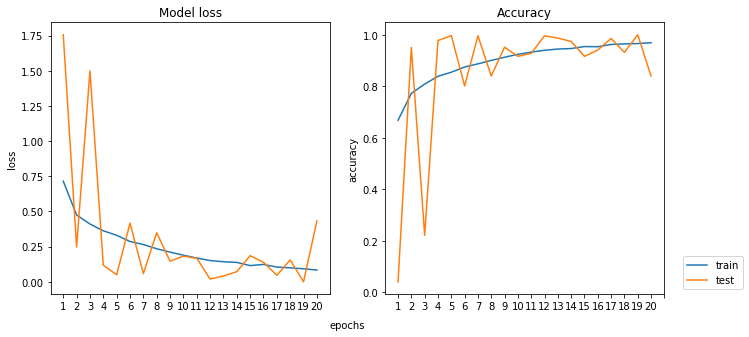

The test accuracy is:  0.30986

The confusion matrix: 
[[ 5  5]
 [44 17]]


In [16]:
plot_history(history_tl)
predict_test_accuracy(model)

#### Fine-tune the model

For fine-tuning, we use the results of transfer learning to initialize the training and then fine-tune the weights of the pre-trained network via backpropagation. Specifically, we freeze the bottom and mid-layers of the InceptionV3 model and retrain the top two inception-block layers. The learning rate (lr) is reduced so that small incremental changes are made to the learned weights while training.

In [18]:
def setup_to_finetune(model):
  """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.
     The NB_IV3_LAYERS corresponds to the second last inception block in the InceptionV3 network.
  """

  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
setup_to_finetune(model)

In [ ]:
filepath = 'wbc_binary_finetune.h5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', verbose=1,save_best_only=False,
                             save_weights_only=False, mode='auto',period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)
callbacks = [checkpoint, reduce_lr]


history_ft = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=NB_EPOCHS,
    shuffle=True,
    batch_size=BATCH_SIZE,
    callbacks=callbacks)

#### Test Results

In [24]:
predict_test_accuracy(model)

The test accuracy is:  0.36620

The confusion matrix: 
[[ 8  2]
 [43 18]]


The train and validation accuracy both after transfer learning and fine-tuning were at least above 95% but for the test accuracy we were not able to get over 36% (this number was in fact lower in most of our various experiments).
A LeNet-like model (with approximately one million parameters) where transfer learning was not applied, however, gave an [98.6% test accuracy](https://github.com/dhruvp/wbc-classification/blob/master/notebooks/binary_training.ipynb).

#### Remarks

There are many computer vision tasks where transfer learning has been used very successfully with small data sets.
In this exercise we experimented with different transfer learning and fine-tuning configurations but were unable to get good inference results on the WBC data. We tried VGG16 and InceptionV3 models pretrained with ImageNet and also experimented with the top layer network configuration. Measures such as aggressive augmentation and re-balancing had already been applied to the data at the pre-processing stage and this left us with few options to improve the results. Stained images of cell nucleation patterns are very different from the natural images used in ImageNet or the features computed from them in the last few ConvNet layers. Here we have an example where  transfer learning (with Inception and VGG models pre-trained on ImageNet weights) is not suitable for classification. 

<div style="background-color: #FAAC58; margin-left: 0px; margin-right: 20px; padding-bottom: 8px; padding-left: 8px; padding-right: 8px; padding-top: 8px;">


Author:  Meena Mani  <br>
Email:   meenas.mailbag@gmail.com   <br> 
Twitter: @meena_uvaca    <br>
</div>